In [1]:
# Problem 2: Probabilistic Road Maps (PRM)
import numpy as np
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline
import random as rnd
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy

In [2]:
DELTA_T = 0.1

In [3]:
class MotionPlanner:

    def __init__(self, planner, path, objective, eps=0.5, delta=0.01, plot=False):
        # Planning
        self.planner = planner
        self.path = path
        self.eps = eps        # linear distance tolerance
        self.delta = delta    # angular distance tolerance
        
        # State
        self.state = np.zeros((3, 1))
        self.state[:2, 0] = self.planner.initial[:, :2]
        self.u = np.zeros((2, 1))

        # Params
        self.delta_t = DELTA_T
        self.K_v = 0.5
        self.K_w = 1.0
        self.l = 0.45
        self.objective = objective
        self.plot = plot

        # Plotting
        self.history = []
        self.history.append(self.state.T)
        self.ground_truth = []
#         self.ground_truth.append(self.state)
        self.views = []

    
    def cmd_vel(self, v, w):
        """
        Simulate velocity input:
            v: linear velocity
            w: angular velocity
        """
        self.u[0] = v
        self.u[1] = w
    
    
    def lin_vel_ctrl(self, goal):
        """
        Linear velocity controller (P controller)
        """
        v = self.K_v * self.dist(goal, self.state[:2].T)
        return v
    
    
    def ang_vel_ctrl(self, goal):
        """
        Angular velocity controller (P controller)
        """
        w = self.K_w * (self.steering_angle(goal) - self.state[2, 0])
        return w

    
    def dist(self, x, y):
        """
        Distance metric (Euclidean)
        """
        return np.sqrt(-2 * np.dot(x, y.T) + np.sum(y**2, axis=1) + np.sum(x**2, axis=1)[:, np.newaxis])
    
    
    def ang_diff(self, theta1, theta2):
        """
        Returns the angular difference between the desired and current heading angle
        """
        return np.min((abs(theta1 - theta2), (2*np.pi - abs(theta1 - theta2))))
    
    
    def steering_angle(self, goal):
        """
        Return required steering angle (radians)
        """
        return np.arctan2(goal[0, 1] - self.state[1], goal[0, 0] - self.state[0])
    


    def motion_model(self, state):
        new_state = np.zeros((3, 1))
        new_state[0, 0] = state[0, 0] + self.delta_t*self.u[0]*np.cos(state[2, 0])
        new_state[1, 0] = state[1, 0] + self.delta_t*self.u[0]*np.sin(state[2, 0])
        new_state[2, 0] = state[2, 0] + self.delta_t*self.u[1]
        return new_state

    
    def close_enough(self, t):
        dist = np.sqrt((self.goal[0]*0.1-self.state[0, 0])**2 + (self.goal[1]*0.1-self.state[1, 0])**2)
        return  dist < self.eps
    
    
    def plot_path(self, data, gt, scenic, title=""):
        """
        Plot robot position and orientation along scenic route
        """
        fig = plt.figure(figsize=(36, 12))
        plt.imshow(planner.grid, cmap=plt.cm.gray_r)
        n = len(data)
        # Ground truth plot
        ground = np.array(gt)
        plt.scatter(ground[:, 0, 1], ground[:, 0, 0], c='c', s=25)
        plt.plot(ground[:, 0, 1], ground[:, 0, 0], c='c', label="ground truth")
        
        # Actual
        for i in range(0, n, 2):
            plt.scatter(data[i][0][1], data[i][0][0], s=20.25, color='r')
            plt.arrow(x=data[i][0][1],
                      y=data[i][0][0],
                      dx=2*np.cos(data[i][0][2]),
                      dy=2*np.sin(data[i][0][2]),
                      width=0.1,
                      head_width=0.8,
                      head_length=0.5,
                      color='r')
        # Scenic views
        s = len(scenic)
        for i in range(s):
#             print(scenic[i])
            plt.scatter(scenic[i][0][1], scenic[i][0][0], s=20.25, color='g')
            plt.arrow(x=scenic[i][0][1],
                      y=scenic[i][0][0],
                      dx=3*np.cos(scenic[i][0][2]),
                      dy=3*np.sin(scenic[i][0][2]),
                      width=0.1,
                      head_width=0.8,
                      head_length=0.5,
                      color='g')
        plt.legend()
            
#         plt.savefig("a2_" + title + ".png", dpi=100)
            
        

    # Waypoint navigation
    def run(self):
        # Save ground truth data for visualization
        print("Objective {}!".format(self.objective))
        self.ground_truth += self.path
        waypoints = self.path
        num_waypoints = len(waypoints)    
        start = waypoints[0]
        finish = waypoints[-1]
        for j in range(1, num_waypoints):
            print("Waypoint {}: {}".format(j, waypoints[j]))
            goal = waypoints[j]
            # Go-to-goal behaviour
            # NOTE: need to change goal (Y, X) --> (X, Y)
            dist = self.dist(goal[::-1], self.state[:2].T)
            old_dist = 0
            limit = None
            while self.dist(goal[::-1], self.state[:2].T) > self.eps:
                old_dist = dist
                dist = self.dist(goal[::-1], self.state[:2].T)
                # Prevent robot from diverging
                if dist > old_dist:
                    if limit is None:
                        limit = old_dist + 0.5

                # Update velocity commands
                if limit is not None and dist > limit:
                    print("Need to reposition robot (turn in place)")
                    heading = np.arctan2(goal[::-1][0, 1] - self.state[1], goal[::-1][0, 0] - self.state[0])
                    while self.ang_diff(heading[0], self.state[-1][0]) > self.delta:
                        v = 0
                        w = self.ang_vel_ctrl(goal[::-1])
                        self.cmd_vel(v, w)
                        self.state = self.motion_model(self.state)
                        limit = None
                else: 
                    v = self.lin_vel_ctrl(goal[::-1])
                    w = self.ang_vel_ctrl(goal[::-1])
                    self.cmd_vel(v, w)

                    # Update motion state
                    self.state = self.motion_model(self.state)

            # Waypoint reached
            print("Goal {} ({}) reached! ({})".format(j, self.state, waypoints[j]))
            self.history.append(self.state.T)

        # Turn-in-place behaviour
        print("Scenic point {} ({}) reached! ({})".format(self.objective, self.state, self.planner.waypoint[:2]))
        heading = self.planner.waypoint[0, -1]
        print("Desired heading: {}".format(heading))
        while self.ang_diff(heading, self.state[-1]) > self.delta:
            # Update velocity commands (constant turning angle)
            v = 0
            w = 0.5
            self.cmd_vel(v, w)

            # Update motion state
            self.state = self.motion_model(self.state)
        print("What a view at {}! ({})".format(self.state[2, 0], heading))
        self.views.append(self.state.T)
        print("So long Blockville!")

In [4]:
class Node:
    def __init__(self, index=None, parent=None, position=None):
        """
        Node class to represent various waypoints in roadmap
            index: index of node in samples
            parent: parent node in roadmap
            position: Y, X coordinates in configuration space (shape: (2, 1))
        """
        self.index = index
        self.parent = parent
        self.position = position
        self.g = 0
        self.h = 0
        self.f = 0
    
    
    def __eq__(self, other):
        return (self.position == other.position).all()
    
    def __lt__(self, other):
        return self.f < other.f
    
    def __le__(self, other):
        return self.f <= other.f
    
    def __gt__(self, other):
        return self.f > other.f
    
    def __ge__(self, other):
        return self.f >= other.f

In [5]:
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []
    
    def empty(self):
        return len(self.elements) == 0
    
    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))
    
    def get(self):
        return heapq.heappop(self.elements)[1]

In [6]:
class Roadmap:
    def __init__(self, points):
        """
        Undirected graph G=(V, E) representing potential roadmaps in the configuration space
            N: maximum number of path searching iterations
        """
        self.n = points.shape[0]
        self.G = np.zeros((self.n, self.n))
        self.points = points # 2D array of sampled (Y, X) points
        print("sample size: {}".format(self.n))
  

    def init_adj_matrix(self, connections, collisions):
        """
        Construct the adjacency matrix G based on valid closest neighbour connections
        """
        for i in range(self.n):
            valid = connections[i][~collisions[i]]
            self.G[i][valid[1:]] = 1
    
    
    def adj_list(self, node):
        """
        Returns the adjacency list of the current node
        """
        neighbours = np.where(self.G[node.index])
        return neighbours, self.points[neighbours]


    def dfs(self, visited, start):
        """
        Depth-first search of the graph to infer its connectivity
        """
        visited[start] = True
        for i in range(self.n):
            if self.G[start][i] == 1 and not visited[i]:
                self.dfs(visited, i)
        return visited
        
    
    def connectivity_check(self, start, goal):
        """
        Post-processing check to ensure G(V, E) is connected from start to goal (at least)
            start: index of start node
            goal: index of goal node
        """
        # start -> goal
        visited = [False] * self.n
        connectivity = self.dfs(visited, start)
        connected_sg = connectivity[goal]
        # goal -> start
        visited = [False] * self.n
        connectivity = self.dfs(visited, goal)
        connected_gs = connectivity[start]
        print("Connectivity: SG: {}, GS: {}".format(connected_sg, connected_gs))
        return connected_sg, connected_gs
        

    def dist(self, x, y):
        """
        Distance metric (squared L2 norm)
        """
        return -2 * np.dot(x, y.T) + np.sum(y**2, axis=1) + np.sum(x**2, axis=1)[:, np.newaxis]
  

    def a_star(self, start, goal, reverse=False):
        """
        Performs A* on roadmap to determine optimal path from start to goal
            reverse: if true, run a* from goal to start
        """
        print(start, goal)
        # Initialization
        start_index = np.argwhere((self.points==start).all(1))
        if len(start_index) == 0:
            print("Invalid start position")
            return []

        end_index = np.argwhere((self.points==goal).all(1))
        if len(end_index) == 0:
            print("Invalid goal position")
            return []
        
        start_node = Node(index=start_index[0][0], parent=None, position=np.array([start]))
        start_node.g = start_node.h = start_node.f = 0
        end_node = Node(index=end_index[0][0], parent=None, position=np.array([goal]))
        end_node.g = end_node.h = end_node.f = 0
        print("start: {}, end: {}".format(start_node.position, end_node.position))

        front = PriorityQueue()
        front.put(start_node, start_node.f)
        came_from = {}
        cost_so_far = {}
        came_from[start_node.index] = None
        cost_so_far[start_node.index] = 0
        success = False
        while not front.empty():
            current = front.get()
            
            if current == end_node:
                print("Done")
                success = True
                break
            indices, neighbours = self.adj_list(current)
            for i, n in zip(indices[0], neighbours):
                next_node = Node(index=i, position=np.array([n]))
                new_cost = cost_so_far[current.index] + self.dist(next_node.position, current.position)[0][0]
                if next_node.index not in cost_so_far or new_cost < cost_so_far[next_node.index]:
#                 if new_cost < cost_so_far.get(next_node.index, np.inf):
                    cost_so_far[next_node.index] = new_cost
                    next_node.f = new_cost + self.dist(end_node.position, next_node.position)[0][0]
                    front.put(next_node, next_node.f)
                    came_from[next_node.index] = current.index
        # Reconstruct 
        if not success:
            print("Couldn't find a path")
            return []
        current = end_node.index
        path = []
        while current != start_node.index:
            path.append(np.array([self.points[current]]))
            current = came_from[current]
        path.append(np.array([self.points[start_node.index]]))
        if not reverse:
            path.reverse()
        return path
            


In [7]:
class PRMPlanner:

    def __init__(self, grid, n=100, k=5, q_max=10, plot=False):
        """
        Probabilistic roadmap path planner
            n: number of uniform random samples from configuration space
            k: number of closest neighbours
            q_max: maximum number of queries allowed before configuration is resampled
        """
        # Map characteristics
        self.grid = grid
        self.obstacles = self.pre_process(deepcopy(grid))
        self.plot = plot
        
        # Parameters
        self.k = k
        self.n = n
        self.Q = q_max
        
        # Path building
        self.initial = None
        self.waypoint = None
        self.roadmap = None
        self.lattice = self.build_roadmap(n)

        
    def pre_process(self, grid):
        """
        Modify environment to meet planning constraints
        Returns the obstacles found in the environment
        """
        # Add 3px buffer space around obstacles to account for robot baseline (b/2 = 0.45m -> 5/2px -> 3px)
        buffer = 3
        dist = 1
        y_end, x_end = grid.shape
        for j in range(buffer):
            closest_y, closest_x = np.where(grid==1)
            num = closest_x.shape[0]
            for i in range(num):
                grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] = np.where(grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)] == 0, 
                                                                                                                                  1,
                                                                                                                                  grid[max(closest_y[i]-1,0):min(closest_y[i]+2,y_end), max(closest_x[i]-1,0):min(closest_x[i]+2,x_end)])

        obstacles = np.argwhere(grid==1)
        return obstacles
            
        
    # NOTE: sacrifice efficiency for simplicity
    # Assign large n to "guarantee" suitable coverage of the configuration space
    # thus precluding the need to grow the graph at subsequent steps
    def build_roadmap(self, n):
        """
        Find path through waypoints by first constructing a roadmap and then querying it for a suitable path
        Returns a list of waypoints if successful (i.e., complete path)
        """
        # Uniformly sample Q_free and remove obstacles
        samples = np.random.randint(self.grid.shape[0], size=(n, 2))
        mask = np.array([(samples[i]==self.obstacles).all(1).any() for i in range(samples.shape[0])])
        samples = samples[~mask]
        
  
        # Generic roadmap construction
        self.roadmap = Roadmap(samples)
        neighbours, collisions = self.nearest_neighbours(samples)
        self.neigh = neighbours
        self.coll = collisions
        self.roadmap.init_adj_matrix(neighbours, collisions)
        self.plot_grid(grid=self.grid, points=samples, adj=self.roadmap.G, title="original_lattice", mode=4)
        
        return samples

    def query(self, start, goal):
        """
        Extend and query existing roadmap to find a path between start and goal
        (easiest way is to rebuild the graph by appending the start and goal to the existing samples)
        """
        # Add start and goal nodes --> rebuild graph
        self.initial = np.array([start])
        start_node = self.initial[:, :2]
        self.waypoint = np.array([goal])
        goal_node = self.waypoint[:, :2]
        samples = np.concatenate((start_node, goal_node, self.lattice))
        self.roadmap = Roadmap(samples)
        neighbours, collisions = self.nearest_neighbours(samples)
        self.roadmap.init_adj_matrix(neighbours, collisions)

        # Path finding
        path = self.roadmap.a_star(start_node[0], goal_node[0])
        connected_sg, connected_gs = self.roadmap.connectivity_check(0, 1)
        if not connected_sg and connected_gs: # re-apply a* from goal to start
            path = self.roadmap.a_star(goal_node[0], start_node[0], reverse=True)
            connected_sg, connected_gs = self.roadmap.connectivity_check(0, 1)
        
        # Allow self.Q more attempts to grow the graph and find a path
        iteration = 0        
        while not path and iteration < self.Q:
            # Add start and goal nodes --> rebuild graph
            print("Resizing: {}".format(iteration))
            new_samples = np.random.randint(self.grid.shape[0], size=(int(self.n/10.), 2)) # insert 1/10 of original sampling size
            samples = np.concatenate((start_node, goal_node, new_samples, self.roadmap.points))
            self.roadmap = Roadmap(samples)
            neighbours, collisions = self.nearest_neighbours(samples)
            self.roadmap.init_adj_matrix(neighbours, collisions)
        
            # Path finding
            path = self.roadmap.a_star(start_node[0], goal_node[0])
            connected_sg, connected_gs = self.roadmap.connectivity_check(0, 1)
            if not connected_sg and connected_gs: # re-apply a* from goal to start
                path = self.roadmap.a_star(goal_node[0], start_node[0], reverse=True)
                connected_sg, connected_gs = self.roadmap.connectivity_check(0, 1)
            iteration += 1
        
        print("Path: {}".format(path))
        
        
        # Plotting
        waypoints = start_node.copy()
        waypoints = np.append(waypoints, goal_node, axis=0)
        title = "roadmap_start(" + str(start_node[0]) + ")"
        self.plot_grid(grid=self.grid, points=self.roadmap.points, adj=self.roadmap.G, path=path, waypoints=waypoints, title=title, mode=4)
        
        return path
            

    def nearest_neighbours(self, points):
        """
        Identify k-1 valid nearest neighbours of each Q_free sample and waypoints based on dist metric
        """
        distances = self.dist(points, points)
        nearest_neighbours = np.argsort(distances, axis=1)[:, :self.k]
        valid_connections = np.ones_like(nearest_neighbours, dtype=bool) # all true
        for i in range(nearest_neighbours.shape[0]):
            mask = self.collision_check(points[nearest_neighbours[i]])
            valid_connections[i] = mask
        return nearest_neighbours, valid_connections
 

    def collision_check(self, points):
        """
        Check for collisions between a sample and its k-1 closest neighbours based on the intersection
        of Bresenham line coordinates and the known obstacle coordinates
            points: k closest neighbours with points[0] being the sample of interest
        """
        start = points[0]
        collisions = np.zeros(points.shape[0], dtype=bool) # all false
        for i in range(1, points.shape[0]):
            line = self.bresenham(start, points[i])
            # Check for an interesection betwen the line and the obstacles
            collisions[i] = np.array([(line[j]==self.obstacles).all(1).any() for j in range(line.shape[0])]).any()
        return collisions

    
    def dist(self, x, y):
        """
        Distance metric (squared L2 norm)
        """
        return -2 * np.dot(x, y.T) + np.sum(y**2, axis=1) + np.sum(x**2, axis=1)[:, np.newaxis]
   

    def bresenham(self, start, end):
        """
        Bresenham line algorithm (source: MTE-544 course content)
            x1, y1: start position (shape: (2, 1))
            x2, y2: end position (shape: (2, 1))
            output: line coordinates from (x1, y1) to (x2, y2) (shape: (x, 2))
        """
        # FIXME: might need to change indices below
        x1 = round(start[0])
        x2 = round(end[0])
        y1 = round(start[1])
        y2 = round(end[1])

        dx = abs(x2 - x1)
        dy = abs(y2 - y1)

        steep = dy > dx
        if steep:
            t = dx
            dx = dy
            dy = t

        if dy == 0:
            q = np.zeros([int(dx + 1), 1])
        else:
            q = [a for a in np.arange(floor(dx / 2), -dy * dx + floor(dx / 2) - dy, -dy)]
            q = np.hstack([0, (np.diff(np.mod(q, dx)) >= 0).astype(float)])

        if steep:
            if y1 <= y2:
                y = np.arange(y1, y2 + 1)
            else:
                y = np.arange(y1, y2 - 1, -1)
            if x1 <= x2:
                x = x1 + np.cumsum(q)
            else:
                x = x1 - np.cumsum(q)
        else:
            if x1 <= x2:
                x = np.arange(x1, x2 + 1)
            else:
                x = np.arange(x1, x2 - 1, -1)
            if y1 <= y2:
                y = y1 + np.cumsum(q)
            else:
                y = y1 - np.cumsum(q)
        return np.concatenate((np.array([x]).T, np.array([y]).T), axis=1)

    
    def plot_grid(self, grid=None, points=None, U=None, V=None, adj=None, path=None, waypoints=None, title="title", mode=-1):
        """
        Helper function to plot various grid types
        """
        if self.plot:
            fig = plt.figure(figsize=(24, 12))
            if mode == 0:
                plt.imshow(grid)
                plt.colorbar()
#                 plt.savefig(title + ".png", dpi=200)
            elif mode == 1:
                quiv, ax1  = plt.subplots()
                ax1.quiver(U, V)
#                 plt.savefig(title + ".png", dpi=200)
            elif mode == 2:
                surf = plt.figure()
                X, Y = np.meshgrid(np.arange(0, grid.shape[0], 1), np.arange(0, grid.shape[1], 1))
                ax = surf.gca(projection='3d')
                ax.plot_surface(X, Y, grid, alpha=0.8)
                ax.set_xlabel('x')
                ax.set_ylabel('y')
                ax.set_zlabel('U')
#                 plt.savefig(title + ".png", spi=200)
            elif mode == 3: # plotting map and distribution of scatter points
                # REQUIRES: grid, points
                plt.imshow(grid, cmap=plt.cm.gray_r)
                plt.scatter(points[:, 1], points[:, 0], c="r", s=10)
            elif mode == 4: # plotting map and adjacency matrix
                # REQUIRES: grid, points, adj, waypoints
                # OPTIONAL: path(s)
                plt.imshow(grid, cmap=plt.cm.gray_r)
                
                n = adj.shape[0]
                x = []
                y = []
                for i in range(n):
                    x = []
                    y = []
                    x.append(points[i][1])
                    y.append(points[i][0])
                    p2_idx = np.where(adj[i])[0]
                    for j in p2_idx:
                        x.append(points[j][1])
                        y.append(points[j][0])
                        plt.plot(x, y, 'ro-')
                        x.pop()
                        y.pop()
                
                # Overlay start and waypoints in different color
                if waypoints is not None:
                    plt.scatter(points[:2, 1], points[:2, 0], marker="v", c="b", s=500)
                
                # Overlay path segment if available
                if path is not None:
                    n = len(path)
                    for i in range(n):
                        plt.plot(path[i][0, 1], path[i][0, 0], 'bo-')
                
            else:
                print("Plotting mode not recognized!")

            plt.title(title)
#             plt.savefig("a2_" + title + ".png", dpi=100)
#             plt.show()

In [8]:
# Utils
def read_pgm(pgmf):
    """
    Read pgm map as numpy array
    """
    with open( pgmf, 'rb' ) as f:
        #Return a raster of integers from a PGM as a list of lists
        header =  f.readline()
        # print( header[0], header[1] )
        assert header == b'P5\n'
        while True:
            l = f.readline()
            if not l[0] == 35:   # skip any header comment lines
                break
        (width, height) = [int(i) for i in l.split()]
        depth = int(f.readline())
        assert depth <= 255

        raster = []
        for y in range(height):
            row = []
            for y in range(width):
                row.append(ord(f.read(1)))
            raster.append(row)
    return np.array(raster)

sample size: 254
sample size: 256
[5. 5.] [15. 70.]
start: [[5. 5.]], end: [[15. 70.]]
Couldn't find a path
Connectivity: SG: False, GS: True
[15. 70.] [5. 5.]
start: [[15. 70.]], end: [[5. 5.]]
Done
Connectivity: SG: False, GS: True
Path: [array([[5., 5.]]), array([[ 7., 11.]]), array([[ 7., 20.]]), array([[ 7., 30.]]), array([[ 4., 39.]]), array([[18., 40.]]), array([[21., 42.]]), array([[20., 56.]]), array([[20., 66.]]), array([[15., 70.]])]
Objective 1!
Waypoint 1: [[ 7. 11.]]
Goal 1 ([[ 7.33479952]
 [10.63852743]
 [ 2.25009663]]) reached! ([[ 7. 11.]])
Waypoint 2: [[ 7. 20.]]
Goal 2 ([[ 6.72536474]
 [19.60086619]
 [ 1.00157528]]) reached! ([[ 7. 20.]])
Waypoint 3: [[ 7. 30.]]
Goal 3 ([[ 7.24701995]
 [29.57089077]
 [ 2.06590282]]) reached! ([[ 7. 30.]])
Waypoint 4: [[ 4. 39.]]
Goal 4 ([[ 4.07816536]
 [38.51883932]
 [ 1.74114497]]) reached! ([[ 4. 39.]])
Waypoint 5: [[18. 40.]]
Goal 5 ([[17.81838843]
 [40.46309381]
 [-1.16443677]]) reached! ([[18. 40.]])
Waypoint 6: [[21. 42.]]
Goal

sample size: 256
[50. 90.] [95. 30.]
start: [[50. 90.]], end: [[95. 30.]]
Done
Connectivity: SG: True, GS: True
Path: [array([[50., 90.]]), array([[46., 84.]]), array([[42., 80.]]), array([[47., 74.]]), array([[50., 71.]]), array([[57., 71.]]), array([[63., 70.]]), array([[67., 65.]]), array([[69., 62.]]), array([[73., 59.]]), array([[80., 60.]]), array([[83., 53.]]), array([[83., 48.]]), array([[89., 43.]]), array([[88., 34.]]), array([[95., 30.]])]
Objective 3!
Waypoint 1: [[46. 84.]]
Need to reposition robot (turn in place)
Goal 1 ([[46.3408381 ]
 [84.34482815]
 [-2.34971925]]) reached! ([[46. 84.]])
Waypoint 2: [[42. 80.]]
Goal 2 ([[42.35371632]
 [80.34977329]
 [-2.3612414 ]]) reached! ([[42. 80.]])
Waypoint 3: [[47. 74.]]
Goal 3 ([[46.52376304]
 [73.88340841]
 [ 0.18436923]]) reached! ([[47. 74.]])
Waypoint 4: [[50. 71.]]
Goal 4 ([[49.95523776]
 [71.49417351]
 [-1.39767621]]) reached! ([[50. 71.]])
Waypoint 5: [[57. 71.]]
Goal 5 ([[56.75700868]
 [70.57443079]
 [ 0.9906477 ]]) reac

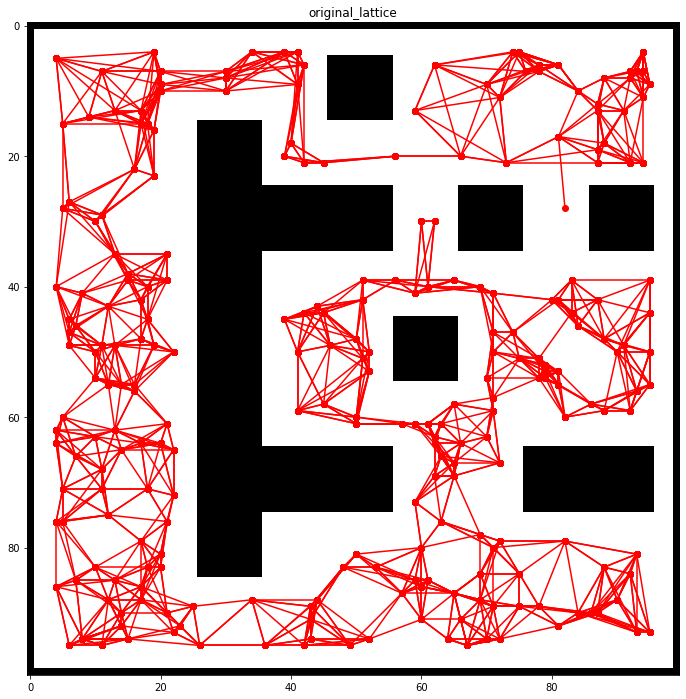

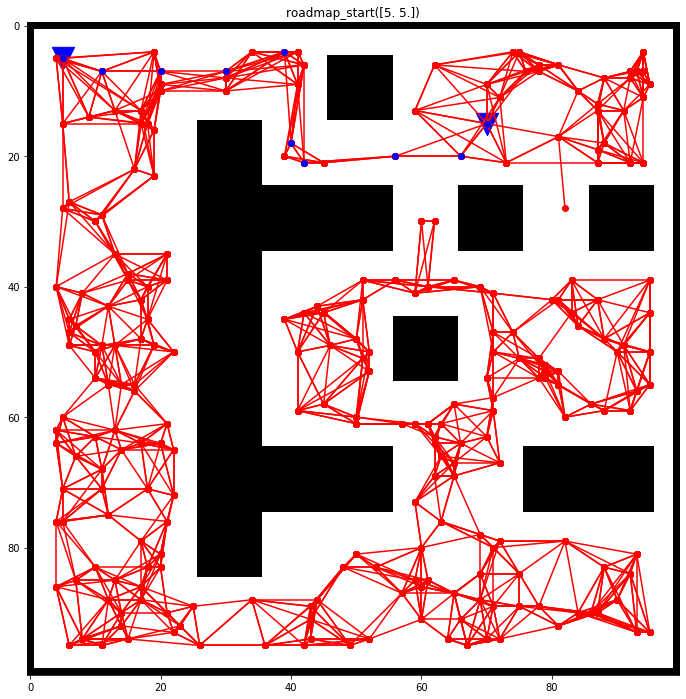

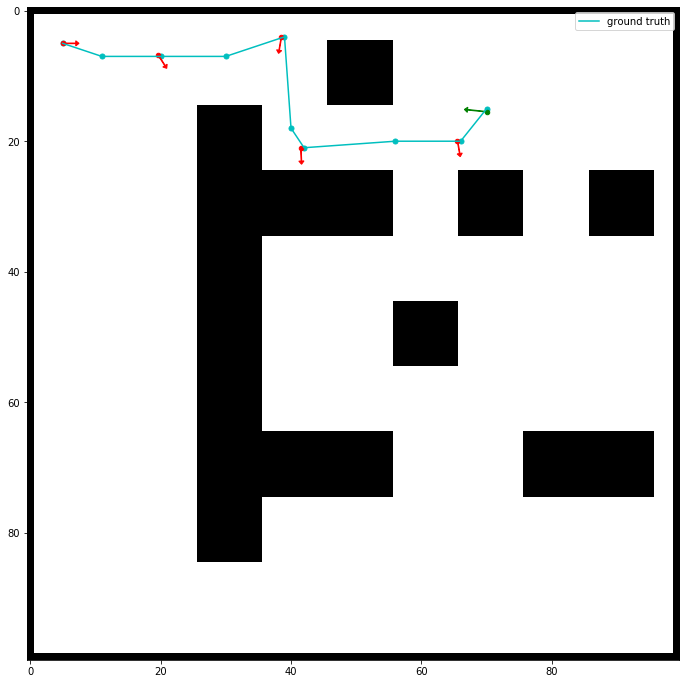

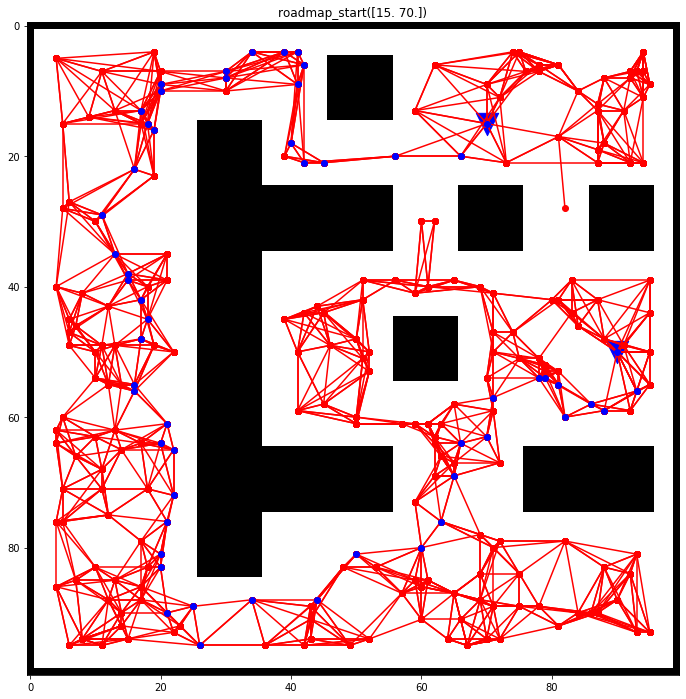

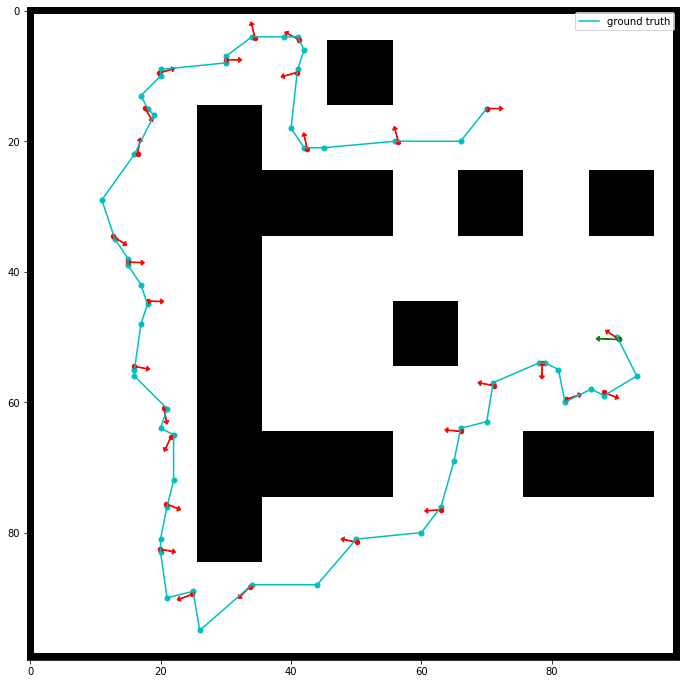

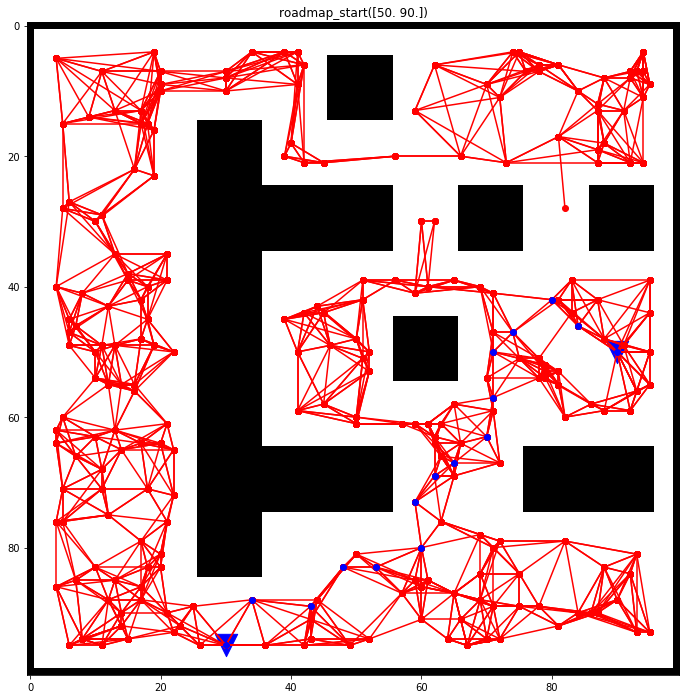

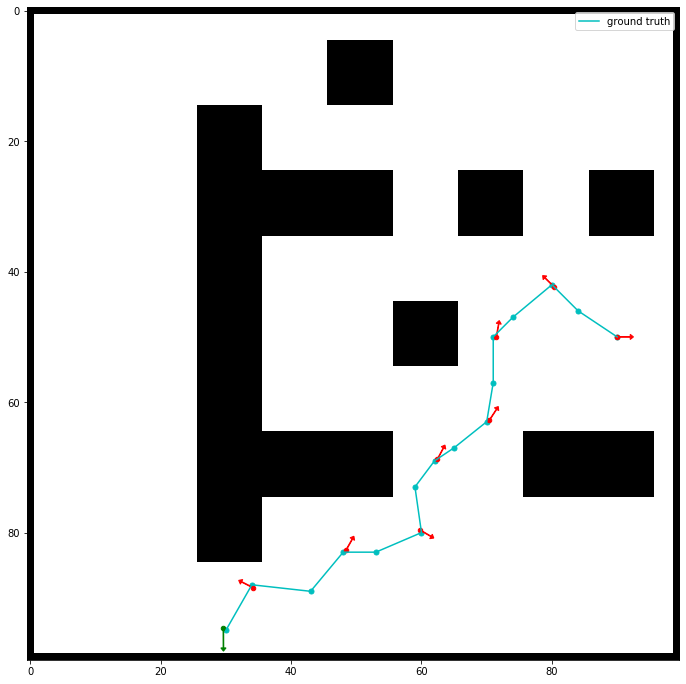

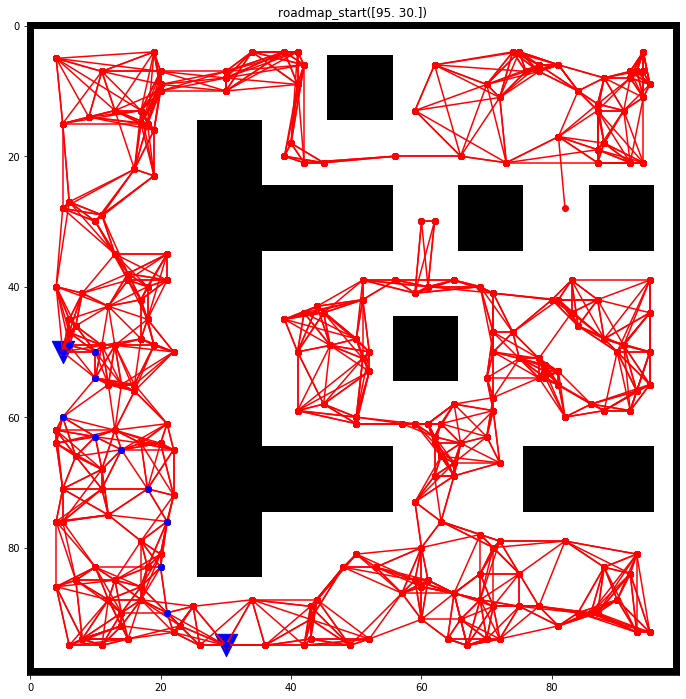

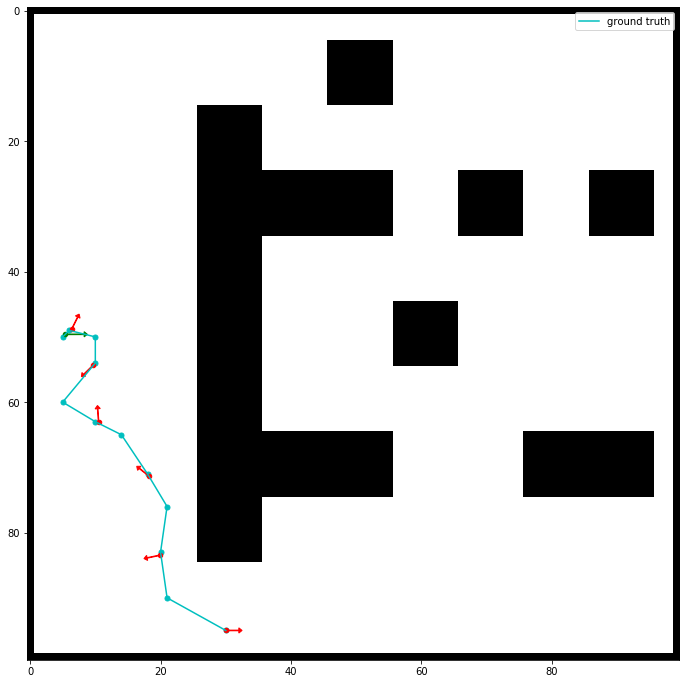

In [9]:
if __name__ == '__main__':
    try:
        # Read pgm map file
        grid = read_pgm('sim_map.pgm')
        grid = np.where(grid==255, 0, 1)
        
        # Waypoints (including scenic viewpoints and orientations)
        waypoints = [(5., 5.),
                     (15, 70, 3*np.pi/2), # waypoint: (Y, X, theta)
                     (50, 90, np.pi),
                     (95, 30, np.pi/2),
                     (50, 5, 0)]
        stops = len(waypoints)
        retries = 10
        planner = PRMPlanner(grid, n=500, k=8, plot=True)
        for w in range(stops-1):
            path = []
            attempt = 0
            # Allow 10 attempts for path planning
            while not path and attempt < retries:
                path = planner.query(waypoints[w], waypoints[w+1])
                attempt += 1
            
            if attempt == retries:
                print("Path planning FAILED!")
                break

            # Motion planning
            motion_planner = MotionPlanner(planner, path, objective=w+1, plot=False)
            motion_planner.run()
            title = "scenic_path_" + str(w)
            motion_planner.plot_path(motion_planner.history, motion_planner.ground_truth, motion_planner.views, title=title)

    except KeyboardInterrupt:
        exit(0)